# Домашняя работа № 3
## Задачи для модели _KNN_:
1. Провести разведочный анализ данных (EDA)
2. Выполните предобработку данных (preprocessing):
	1. Анализ и восстановление пропусков
	2. Стандартизация или нормализация данных 
3. Выполнить обучение модели _KNN_ для востановления регрессии.
4. Оценить качество пресдказания обученной моделипо известным вам мерикам качества (минимум 4 метрики качества). Сфоримровать Pandas DtaraFrame, в котором в строке будет указана модель, а по dертикали метрики каxества. Вывести данный Pandas Data Frame.
5. Иследовать влияние количества соседей k.
6. Иследовать влияние весов (параметр weights) на метрики качества.
7. Иследовать влияние используемых метрик расстояния 'euclidean', 'manhattan', 'chebyshev', 'minkowski' на метрики качества.
8. Поостроить зависимость длительноти обучения и предсказания модели от размера выборки. Сделать вывод о характере этой зависимости.
9. Прверить отсуствие переобучения.
10. Найти лучшие парметры модели _KNN_ методом оптимизации с использованием модуля Optuna.
11. Сделать предсказание с помощью обученной модли и сохранить данный в файл с помщью приведённого кода.

In [57]:
#библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import optuna
import time

from IPython.display import display
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from sklearn.model_selection import cross_val_score


уникальные значения в подозрительной фиче:  [249.  nan]
список фич:  ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'target']
посмотрим, нет ли категориальных признаков
feature_1  имеет  7775  уникальных значений
feature_2  имеет  7790  уникальных значений
feature_3  имеет  7765  уникальных значений
feature_4  имеет  7758  уникальных значений
feature_5  имеет  7745  уникальных значений
feature_6  имеет  7776  уникальных значений
feature_7  имеет  7782  уникальных значений
feature_9  имеет  7764  уникальных значений
feature_10  имеет  7794  уникальных значений
feature_11  имеет  7767  уникальных значений
feature_12  имеет  7769  уникальных значений
feature_13  имеет  7739  уникальных значений
feature_14  имеет  7756  уникальных значений
feature_15  имеет  7764  уникальных значений
feature_16  имеет  7777  уникальных зна

,Unnamed: 0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,target
target,0.012301,-0.027958,-0.018308,-0.008935,0.420905,-0.159593,0.271948,0.18867,NaN,-0.198669,-0.17187,0.173842,-0.029051,-0.532922,0.18434,0.309383,-0.168308,0.343837,1.0


важные фичи (корреляция > 0.15):  ['feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_9', 'feature_10', 'feature_11', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'target']
для простого восприятия матрицы корреляций ☟


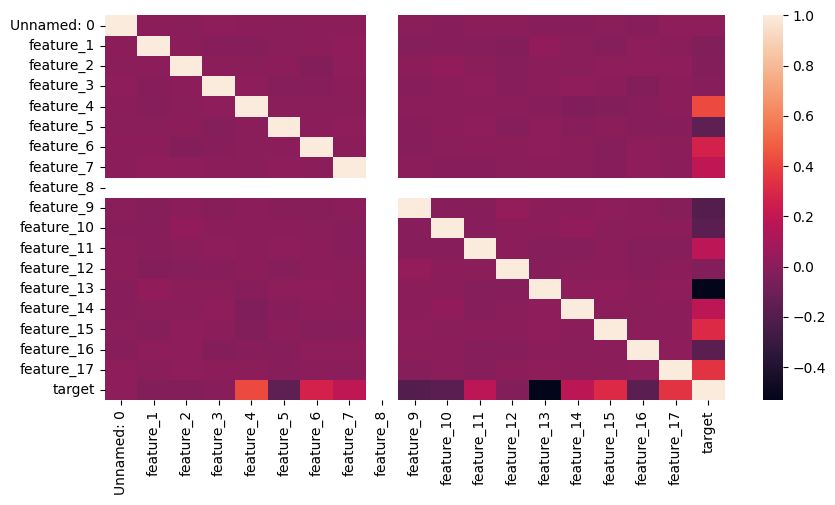

In [140]:
# Здесь выполнять задание 1
data = pd.read_csv('train-HW_3-sid_13.csv')
c = data.corr()
plt.figure(figsize=(10,5))
sns.heatmap(c)
print('уникальные значения в подозрительной фиче: ',data['feature_8'].unique())
columns_list = list(data.columns)
columns_list.remove('feature_8')
columns_list.remove('Unnamed: 0')
print('список фич: ',columns_list)
data = data[columns_list]
print('посмотрим, нет ли категориальных признаков')
for column in columns_list:
    print(column,' имеет ',len(data[column].unique()),' уникальных значений') #нет категориальных признаков
print('нет категориальных признаков')
print('Корреляция фич с таргетом: ')
display(c.tail(1)) # df.tail(n) - возвращает последние n строк
corr_coef = c.tail(1)
important_features = []
for column in columns_list:
    if abs(corr_coef[column].values) > 0.1:
        important_features.append(column)
print('важные фичи (корреляция > 0.15): ',important_features)
important_features.remove('target')
#important_features.remove('feature_2')
for column in important_features:
    value = data[column].mean()
    data[column].fillna(value,inplace=True)
print('для простого восприятия матрицы корреляций ☟')

In [141]:
# Здесь выполнять задание 2
norm_scaler = preprocessing.MinMaxScaler()
std_scaler = preprocessing.StandardScaler()
data_norm = pd.DataFrame(norm_scaler.fit_transform(data), index=data.index, columns=data.columns)
data_norm = data_norm[important_features]
data_std = pd.DataFrame(std_scaler.fit_transform(data), index=data.index, columns=data.columns)
data_std = data_std[important_features]
target = data['target'] #столбец целевой переменной готов -> target
#матрица признаков готова -> data_std и data_norm
print(data_std.head(3))
print('-----------------------')
print(data_norm.head(3))
print('-----------------------')
print(target.head(3))

   feature_4     feature_5  feature_6  feature_7  feature_9  feature_10  \
0   0.408908 -1.041901e+00  -2.180251  -0.560927  -0.893904   -1.225817   
1   0.664249  1.763386e-15   0.024954   1.796910  -0.208996    0.406718   
2  -1.886425  1.812556e-01  -0.717535   0.137107   0.915540   -1.780601   

   feature_11  feature_13  feature_14    feature_15  feature_16  feature_17  
0    1.776794    0.004545   -0.075201  5.272641e-01   -1.086784   -0.224898  
1    0.579444   -0.163936   -0.113335  1.255348e+00    0.311532    0.032734  
2   -0.979165   -1.181509    0.520087  7.360880e-16    0.350010    0.615036  
-----------------------
   feature_4  feature_5  feature_6  feature_7  feature_9  feature_10  \
0   0.484240   0.357838   0.231251   0.461406   0.391615    0.280113   
1   0.518159   0.497412   0.540680   0.748752   0.482968    0.490664   
2   0.179328   0.521693   0.436496   0.546474   0.632959    0.208561   

   feature_11  feature_13  feature_14  feature_15  feature_16  feature_17 

In [142]:
# Здесь выполнять задание 3
MSE_list_n = []
MAE_list_n = []
R2_list_n = []
MAPE_list_n = []
MSE_list_s = []
MAE_list_s = []
R2_list_s = []
MAPE_list_s = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size=0.2)
    knn_model = KNeighborsRegressor()
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    MSE_list_s.append(mean_squared_error(y_test, y_pred))
    R2_list_s.append(r2_score(y_test, y_pred))
    MAE_list_s.append(mean_absolute_error(y_test, y_pred))
    MAPE_list_s.append(mean_absolute_percentage_error(y_test, y_pred))
    
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(data_norm, target, test_size=0.2)
    knn_model = KNeighborsRegressor()
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    MSE_list_n.append(mean_squared_error(y_test, y_pred))
    R2_list_n.append(r2_score(y_test, y_pred))
    MAE_list_n.append(mean_absolute_error(y_test, y_pred))
    MAPE_list_n.append(mean_absolute_percentage_error(y_test, y_pred))

d = {'Метрики': ['std','norm'], 
     'R2': [statistics.mean(R2_list_s),statistics.mean(R2_list_n)],
     'MAE': [statistics.mean(MAE_list_s),statistics.mean(MAE_list_n)],
     'MAPE ': [statistics.mean(MAPE_list_s),statistics.mean(MAPE_list_n)],
     'MSE': [statistics.mean(MSE_list_s),statistics.mean(MSE_list_n)] } 
metrics_knn = pd.DataFrame(d)
print(metrics_knn)

  Метрики        R2        MAE     MAPE            MSE
0     std  0.800827  85.037934  1.693148  12035.339306
1    norm  0.798641  85.020185  1.726448  12074.747063


In [143]:
# Здесь выполнять задание 4
print(metrics_knn)

  Метрики        R2        MAE     MAPE            MSE
0     std  0.800827  85.037934  1.693148  12035.339306
1    norm  0.798641  85.020185  1.726448  12074.747063


с ростом числа соседей все метрики улучшаются кроме MAPE - ей плохо
на значении n_neighbors=5, которое кстати является стандартным, значения метрик выходит на плато


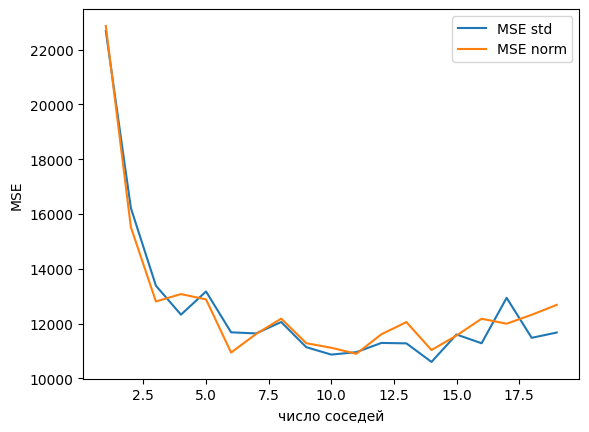

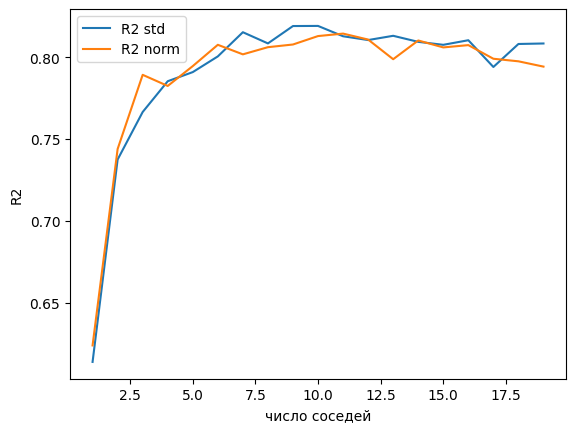

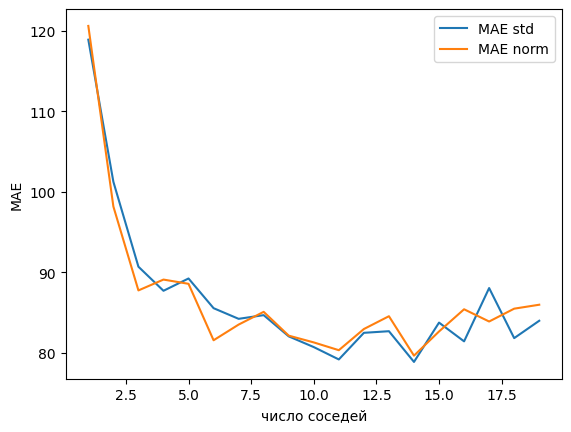

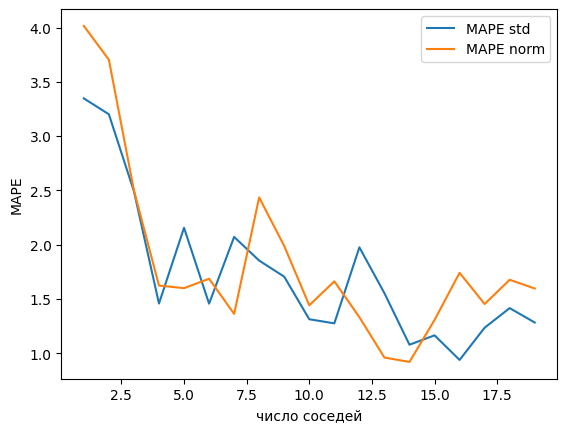

In [144]:
# Здесь выполнять задание 5
MSE_list_n = []
MAE_list_n = []
R2_list_n = []
MAPE_list_n = []
MSE_list_s = []
MAE_list_s = []
R2_list_s = []
MAPE_list_s = []

for i in range(1,20):
    X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size=0.2)
    knn_model = KNeighborsRegressor(n_neighbors=i)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    MSE_list_s.append(mean_squared_error(y_test, y_pred))
    R2_list_s.append(r2_score(y_test, y_pred))
    MAE_list_s.append(mean_absolute_error(y_test, y_pred))
    MAPE_list_s.append(mean_absolute_percentage_error(y_test, y_pred))
    
for i in range(1,20):
    X_train, X_test, y_train, y_test = train_test_split(data_norm, target, test_size=0.2)
    knn_model = KNeighborsRegressor(n_neighbors=i)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    MSE_list_n.append(mean_squared_error(y_test, y_pred))
    R2_list_n.append(r2_score(y_test, y_pred))
    MAE_list_n.append(mean_absolute_error(y_test, y_pred))
    MAPE_list_n.append(mean_absolute_percentage_error(y_test, y_pred))
plt.figure()
plt.plot(range(1,20),MSE_list_s,label='MSE std') 
plt.plot(range(1,20),MSE_list_n,label='MSE norm')
plt.xlabel('число соседей')
plt.ylabel('MSE')
plt.legend()

plt.figure()
plt.plot(range(1,20),R2_list_s,label='R2 std')
plt.plot(range(1,20),R2_list_n,label='R2 norm')
plt.xlabel('число соседей')
plt.ylabel('R2')
plt.legend()

plt.figure()
plt.plot(range(1,20),MAE_list_s,label='MAE std')
plt.plot(range(1,20),MAE_list_n,label='MAE norm')
plt.xlabel('число соседей')
plt.ylabel('MAE')
plt.legend()

plt.figure()
plt.plot(range(1,20),MAPE_list_s,label='MAPE std') 
plt.plot(range(1,20),MAPE_list_n,label='MAPE norm')
plt.xlabel('число соседей')
plt.ylabel('MAPE')
plt.legend()

print('с ростом числа соседей все метрики улучшаются кроме MAPE - ей плохо')
print('на значении n_neighbors=5, которое кстати является стандартным, значения метрик выходит на плато')

In [145]:
# Здесь выполнять задание 6
MSE_list_n = []
MAE_list_n = []
R2_list_n = []
MAPE_list_n = []
MSE_list_s = []
MAE_list_s = []
R2_list_s = []
MAPE_list_s = []
for j in range(10):
    for i in ['uniform', 'distance']:
        X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size=0.2)
        knn_model = KNeighborsRegressor(weights=i)
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        MSE_list_s.append(mean_squared_error(y_test, y_pred))
        R2_list_s.append(r2_score(y_test, y_pred))
        MAE_list_s.append(mean_absolute_error(y_test, y_pred))
        MAPE_list_s.append(mean_absolute_percentage_error(y_test, y_pred))
    
for j in range(10):
    for i in ['uniform', 'distance']:
        X_train, X_test, y_train, y_test = train_test_split(data_norm, target, test_size=0.2)
        knn_model = KNeighborsRegressor(weights=i)
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        MSE_list_n.append(mean_squared_error(y_test, y_pred))
        R2_list_n.append(r2_score(y_test, y_pred))
        MAE_list_n.append(mean_absolute_error(y_test, y_pred))
        MAPE_list_n.append(mean_absolute_percentage_error(y_test, y_pred))

print('std:')
d = {'Метрики': ['uniform','distance'], 
     'R2': [statistics.mean(R2_list_s[1::2]),statistics.mean(R2_list_s[::2])],
     'MAE': [statistics.mean(MAE_list_s[1::2]),statistics.mean(MAE_list_s[::2])],
     'MAPE ': [statistics.mean(MAPE_list_s[1::2]),statistics.mean(MAPE_list_s[::2])],
     'MSE': [statistics.mean(MSE_list_s[1::2]),statistics.mean(MSE_list_s[::2])] } 
print(pd.DataFrame(d))
print('norm:')
d = {'Метрики': ['uniform','distance'], 
     'R2': [statistics.mean(R2_list_n[1::2]),statistics.mean(R2_list_n[::2])],
     'MAE': [statistics.mean(MAE_list_n[1::2]),statistics.mean(MAE_list_n[::2])],
     'MAPE ': [statistics.mean(MAPE_list_n[1::2]),statistics.mean(MAPE_list_n[::2])],
     'MSE': [statistics.mean(MSE_list_n[1::2]),statistics.mean(MSE_list_n[::2])] } 
print(pd.DataFrame(d))
print('проверим, есть ли разница на примере std данных и метрики MAPE:')
t_stat, p_value = stats.ttest_ind(MAPE_list_s[1::2], MAPE_list_s[::2])
alpha = 0.05
if p_value < alpha:
    print("Есть статистически значимая разница между метриками")
else:
    print("Нет статистически значимой разницы между метриками")
    

std:
    Метрики        R2        MAE     MAPE            MSE
0   uniform  0.803479  84.345411  1.717780  11823.980815
1  distance  0.803317  83.477832  1.608841  11571.395434
norm:
    Метрики        R2        MAE     MAPE            MSE
0   uniform  0.801842  85.095666  1.670971  12090.945436
1  distance  0.799879  84.722591  1.803594  11957.391127
проверим, есть ли разница на примере std данных и метрики MAPE:
Нет статистически значимой разницы между метриками


In [146]:
# Здесь выполнять задание 7
MSE_list_n = []
MAE_list_n = []
R2_list_n = []
MAPE_list_n = []
MSE_list_s = []
MAE_list_s = []
R2_list_s = []
MAPE_list_s = []
for j in range(10):
    for i in ['euclidean', 'manhattan', 'chebyshev', 'minkowski']:
        X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size=0.2)
        knn_model = KNeighborsRegressor(metric=i)
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        MSE_list_s.append(mean_squared_error(y_test, y_pred))
        R2_list_s.append(r2_score(y_test, y_pred))
        MAE_list_s.append(mean_absolute_error(y_test, y_pred))
        MAPE_list_s.append(mean_absolute_percentage_error(y_test, y_pred))
    
for j in range(10):
    for i in ['euclidean', 'manhattan', 'chebyshev', 'minkowski']:
        X_train, X_test, y_train, y_test = train_test_split(data_norm, target, test_size=0.2)
        knn_model = KNeighborsRegressor(metric=i)
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        MSE_list_n.append(mean_squared_error(y_test, y_pred))
        R2_list_n.append(r2_score(y_test, y_pred))
        MAE_list_n.append(mean_absolute_error(y_test, y_pred))
        MAPE_list_n.append(mean_absolute_percentage_error(y_test, y_pred))

print('std:')
d = {'Метрики': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'], 
     'R2': [statistics.mean(R2_list_s[0::4]),statistics.mean(R2_list_s[1::4]),statistics.mean(R2_list_s[2::4]),statistics.mean(R2_list_s[3::4])],
     'MAE': [statistics.mean(MAE_list_s[0::4]),statistics.mean(MAE_list_s[1::4]),statistics.mean(MAE_list_s[2::4]),statistics.mean(MAE_list_s[3::4])],
     'MAPE ': [statistics.mean(MAPE_list_s[0::4]),statistics.mean(MAPE_list_s[1::4]),statistics.mean(MAPE_list_s[2::4]),statistics.mean(MAPE_list_s[3::4])],
     'MSE': [statistics.mean(MSE_list_s[0::4]),statistics.mean(MSE_list_s[1::4]),statistics.mean(MSE_list_s[2::4]),statistics.mean(MSE_list_s[3::4])] } 
print(pd.DataFrame(d))
print('norm:')
d = {'Метрики': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'], 
     'R2': [statistics.mean(R2_list_n[0::4]),statistics.mean(R2_list_n[1::4]),statistics.mean(R2_list_n[2::4]),statistics.mean(R2_list_n[3::4])],
     'MAE': [statistics.mean(MAE_list_n[0::4]),statistics.mean(MAE_list_n[1::4]),statistics.mean(MAE_list_n[2::4]),statistics.mean(MAE_list_n[3::4])],
     'MAPE ': [statistics.mean(MAPE_list_n[0::4]),statistics.mean(MAPE_list_n[1::4]),statistics.mean(MAPE_list_n[2::4]),statistics.mean(MAPE_list_n[3::4])],
     'MSE': [statistics.mean(MSE_list_n[0::4]),statistics.mean(MSE_list_n[1::4]),statistics.mean(MSE_list_n[2::4]),statistics.mean(MSE_list_n[3::4])] } 
print(pd.DataFrame(d))

print('Таким образом наилучший метод определения расстояния - euclidean')

std:
     Метрики        R2        MAE     MAPE            MSE
0  euclidean  0.803604  85.198590  1.755949  11949.897175
1  manhattan  0.780251  90.552870  1.938638  13395.003532
2  chebyshev  0.755327  94.275687  2.006776  14717.848920
3  minkowski  0.801802  85.209559  1.685937  12006.391746
norm:
     Метрики        R2        MAE     MAPE            MSE
0  euclidean  0.799868  85.429783  1.619474  12030.018196
1  manhattan  0.781139  90.038564  1.568026  13284.794321
2  chebyshev  0.756514  93.748259  1.925888  14593.026311
3  minkowski  0.800989  84.915618  1.866720  11861.227804
Таким образом наилучший метод определения расстояния - euclidean


зависимость времени обучения и предсказания от размера выборки


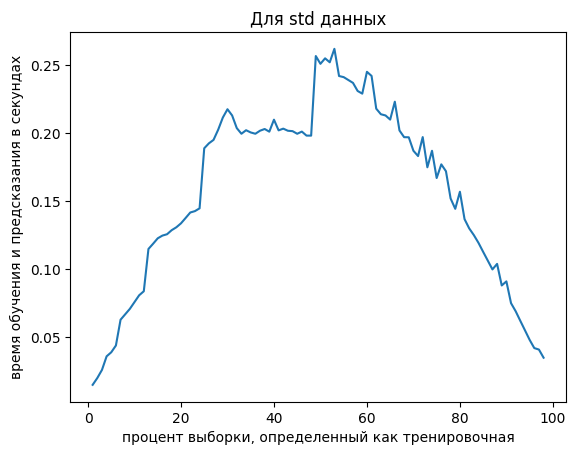

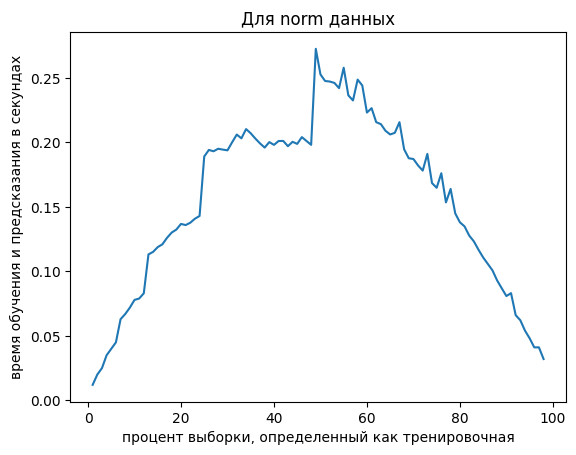

Эта зависимость похожа на квадратичную, с пиком на 50%


In [147]:
# Здесь выполнять задание 8
time_std = []
time_norm = []
for i in range(1,99):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(data_std, target, train_size=0.01*i)
    knn_model = KNeighborsRegressor()
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    time_std.append((time.time() - start_time))
    
for i in range(1,99):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(data_norm, target, train_size=0.01*i)
    knn_model = KNeighborsRegressor()
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    time_norm.append((time.time() - start_time))
print('зависимость времени обучения и предсказания от размера выборки')
plt.figure()
plt.plot(range(1,99),time_std)
plt.xlabel('процент выборки, определенный как тренировочная')
plt.ylabel('время обучения и предсказания в секундах')
plt.title('Для std данных')
plt.figure()
plt.plot(range(1,99),time_norm)
plt.xlabel('процент выборки, определенный как тренировочная')
plt.ylabel('время обучения и предсказания в секундах')
plt.title('Для norm данных')
plt.show()
print('Эта зависимость похожа на квадратичную, с пиком на 50%')

In [148]:
# Здесь выполнять задание 9

X_train, X_test, y_train, y_test = train_test_split(data_std, target, train_size=0.8)
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'на тренировочной выборке MSE = {mse_train :.2f}')
print(f'на тестовой выборке MSE = {mse_test :.2f}')

на тренировочной выборке MSE = 8142.03
на тестовой выборке MSE = 11144.25


In [149]:
# Здесь выполнять задание 10
optuna.logging.set_verbosity(optuna.logging.ERROR)
def objective(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 100),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'leaf_size': trial.suggest_int('leaf_size', 1, 50),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski']),
        'p': trial.suggest_int('p', 1, 10),
    }
    mape_list = []
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size=0.2)
        knn_model = KNeighborsRegressor(**param)
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mape_list.append(mape)
    return statistics.mean(mape_list)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print('Лучшие параметры для KNN:', study.best_params)
print('MAPE для этих параметров:', study.best_value)

Лучшие параметры для KNN: {'n_neighbors': 26, 'weights': 'uniform', 'leaf_size': 12, 'metric': 'minkowski', 'p': 4}
MAPE для этих параметров: 1.1480225880172172


In [150]:
# Здесь выполнять задание 11
data_f = pd.read_csv('test-HW_3-sid_13.csv')
data_f = data_f[important_features]
for column in important_features:
    value = data_f[column].mean()
    data_f[column].fillna(value,inplace=True)
std_scaler = preprocessing.StandardScaler()
data_test_std = pd.DataFrame(std_scaler.fit_transform(data_f), index=data_f.index, columns=data_f.columns)
knn_model = KNeighborsRegressor(**best_params)
knn_model.fit(data_std, target)
predict = knn_model.predict(data_test_std)
print(predict)

[-296.492464    298.21231173  -45.57758539 ...  167.59580474  252.97322286
  259.53589954]


In [151]:
# Воспользуйтесь данным кодом для сохранения предсказанных данных. Не удаляйте эту ячейку.

HW_number = 3 # Здесь нужно указать номер домашнего задания 
student_id = 13# Здесь нужно указать student_id
data = predict # Здесь нужно указать предсказанные моделью данные в формате numpy.array

y_pred = pd.DataFrame(data = data, columns = ['target'])
y_pred.to_csv(f'y_pred-HW_{HW_number}-sid_{student_id}.csv')